In [80]:
#libraries
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
newStopWords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's', 'co']
stop_words = stopwords.words('english')
stop_words.extend(newStopWords)

from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
lematizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
matplotlib.rcParams['figure.figsize'] = (8,7)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# df = pd.read_csv("./data/cyberbullying_tweets.csv")


# !pip install langdetect

# from langdetect import detect, DetectorFactory

# # Language detection algorithm is non-deterministic, 
# # which means that if you try to run it on a text which is either too short or too ambiguous,
# # you might get different results everytime you run it.
# DetectorFactory.seed = 0

# # Detecting language and errors 
# cnt = 0
# for row in X:
#     try : df.loc[cnt, 'language'] = detect(row)
#     except Exception as exception:
#         print("Error in language detection : tweet n°", cnt, "-->", df.tweet_text[cnt])
#     cnt += 1

# df.loc[31676]

# df.to_csv("data/df_with_lang.csv",index=False)

Error in language detection : tweet n° 4011 --> ♪♥♪
Error in language detection : tweet n° 8695 --> 😂😂😂😂😂
Error in language detection : tweet n° 14458 --> 👧👧👧👧 …
Error in language detection : tweet n° 14691 --> ♫♪
Error in language detection : tweet n° 24110 --> ?????????
Error in language detection : tweet n° 24529 --> 5/16/15
Error in language detection : tweet n° 25032 --> 01:15:19:00
Error in language detection : tweet n° 25846 --> 5/14/15
Error in language detection : tweet n° 26069 --> 💃🍦🐙😇🌸🌟
Error in language detection : tweet n° 26461 --> 5/11/15
Error in language detection : tweet n° 27618 --> 5/17/15
Error in language detection : tweet n° 27928 --> 5/13/15
Error in language detection : tweet n° 28228 --> &#128533;
Error in language detection : tweet n° 28468 --> :-)
Error in language detection : tweet n° 28855 --> 💩
Error in language detection : tweet n° 31214 --> 5/12/15
Error in language detection : tweet n° 31286 --> .
Error in language detection : tweet n° 31676 --> 5/10/

In [3]:
df = pd.read_csv("./data/df_with_lang.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
 2   language            47674 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


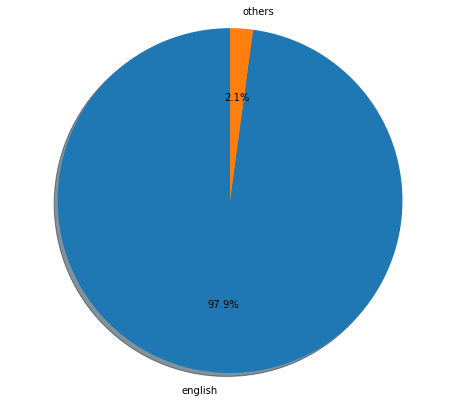

In [81]:
df_lang = pd.Series(df.language).value_counts()[:5].rename_axis('lang').reset_index(name='counts')
df_lang = df_lang.replace({'en':'english',
                           'pt':'others',
                           'af':'others',
                           'da':'others',
                           'cy':'others'})
df_lang = df_lang.groupby('lang').sum().sort_values(by='counts',ascending=False)

index = df_lang.index
values = df_lang.counts

fig1, ax1 = plt.subplots()
ax1.pie(values, labels=index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

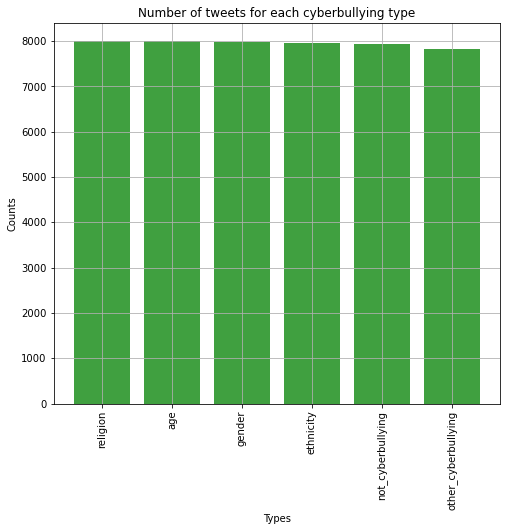

In [82]:
index = df.cyberbullying_type.value_counts().index.tolist()
values = df.cyberbullying_type.value_counts().values.tolist()

plt.bar(index, values, facecolor='g', alpha=0.75)

plt.xlabel('Types')
plt.ylabel('Counts')
plt.title('Number of tweets for each cyberbullying type')
# Rotation of the bar names
plt.xticks(index, rotation=90)
# plt.subplot_adjust(bottom=0.01, top=0.99)

plt.grid(True)
plt.show()

In [6]:
types = {'age':0,
         'ethnicity':1,
         'gender':2,
         'not_cyberbullying':3,
         'other_cyberbullying':4,
         'religion':5}

df['target'] = df['cyberbullying_type'].replace(types, inplace=False)
df[:10]

,tweet_text,cyberbullying_type,language,target
0,"In other words #katandandre, your food was cra...",not_cyberbullying,en,3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,en,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,en,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,en,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,en,3
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,en,3
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying,id,3
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying,en,3
8,@stockputout everything but mostly my priest,not_cyberbullying,en,3
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying,en,3


In [31]:
df_en = df[df.language == 'en']

def clean_text(text):
    
    text = text.apply(lambda x: ''.join(w.lower() for w in x))
    text = text.apply(lambda x: ' '.join(w for w in x.split(" ") if not w.startswith('@')))
    text = text.apply(lambda x: ' '.join([lematizer.lemmatize(w) for w in x.split(" ")]))
    
    mapping = [ ('\d+', ''), ('https?:', ''), ('http?:', '') ]
    for k, v in mapping:
        text = text.str.replace(k, v)

    return text

df_en['tweet_text_tranformed'] = clean_text(df_en.tweet_text) 
df_en.tweet_text_tranformed

0        in other word #katandandre, your food wa crapi...
1        why is #aussietv so white? #mkr #theblock #ima...
2             a classy whore? or more red velvet cupcakes?
3        meh. :p  thanks for the head up, but not too c...
4        this is an isi account pretending to be a kurd...
                               ...                        
47687    black ppl aren't expected to do anything, depe...
47688    turner did not withhold his disappointment. tu...
47689    i swear to god. this dumb nigger bitch. i have...
47690    yea fuck you rt if youre a nigger fucking unfo...
47691    bro. u gotta chill rt dog fuck kp that dumb ni...
Name: tweet_text_tranformed, Length: 44629, dtype: object

In [32]:
random_state = np.random.RandomState(0)

X = df_en.tweet_text_tranformed
y = df_en.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape:  {}".format(X_test.shape))

X_train shape: (31240,)
X_test shape:  (13389,)


In [33]:
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_df=0.7, min_df=4)
# max_df : removes term with DF higher than the 70% of the documents
# min_df : terms must have DF>=4 to be considered

start = time()
X_train_tfidf = vectorizer.fit_transform(X_train)
vec_time = time() - start

print("Extracting features from X using TfidfVectorizer")
print("n_samples: %d, n_features: %d" % X_train_tfidf.shape)
print("TfidfVectorizer takes %fs" % vec_time)

features = vectorizer.get_feature_names_out()

X_test_tfidf = vectorizer.transform(X_test)

features[:10]

Extracting features from X using TfidfVectorizer
n_samples: 31240, n_features: 17850
TfidfVectorizer takes 1.137494s


array(['__', '___', '____', '_xd_', 'aa', 'aaa', 'aaaand', 'ab',
       'abandoned', 'abc'], dtype=object)

In [13]:
def top_tfidf_feats(row, features, top_n=25):
    '''Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)


def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, max_tfidf=0.3, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    D[D > max_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, max_tfidf=0.3, top_n=25):
    '''Return a list of dfs, where each df holds top_n features and their mean tfidf value
       calculated across documents with the same class label.'''
    dfs=[]
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, max_tfidf=max_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [34]:
# row = df_en.tweet_text_tranformed[0]

dfs = top_feats_by_class(X_train_tfidf, y_train, features)

assert len(np.unique(y_train)) == len(dfs)

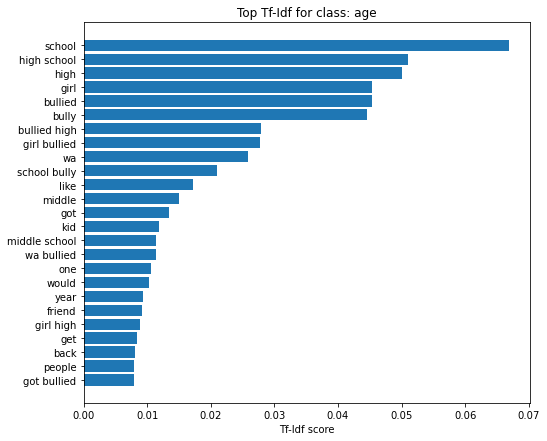

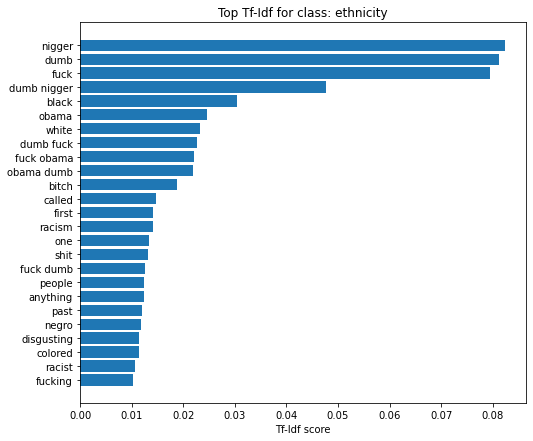

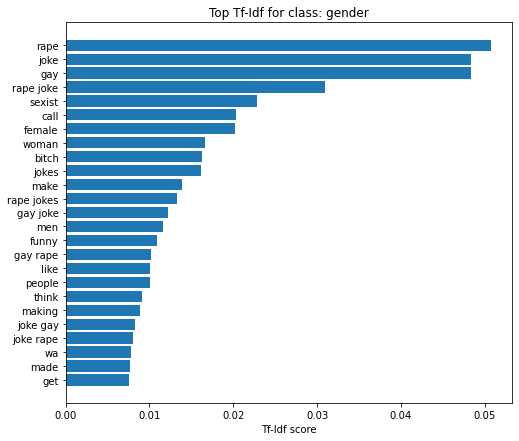

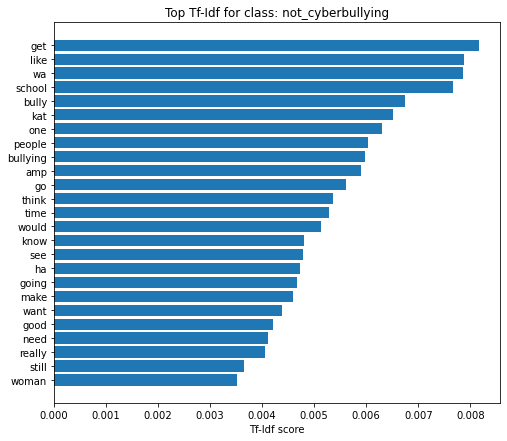

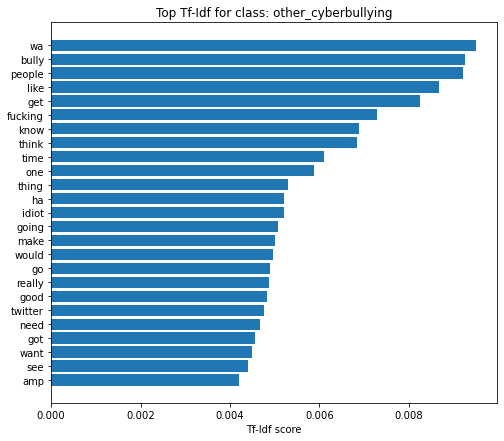

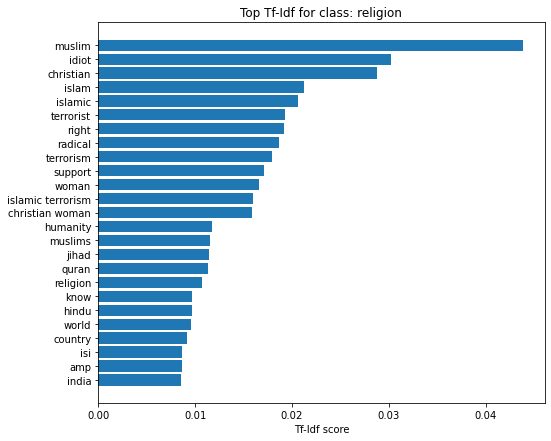

In [97]:
for i in range(len(dfs)):
    words = dfs[i]['feature'].values
    y_pos = np.arange(len(words))
    score = dfs[i]['tfidf'].values

    fig, ax = plt.subplots()
    ax.barh(y_pos, score, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(dfs[i]['feature'].values)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Tf-Idf score')
    ax.set_title('Top Tf-Idf for class: {}'.format(list(types.keys())[list(types.values()).index(np.unique(y_train)[i])]))

    plt.show()


In [39]:
def benchmark(clf, X_train, y_train, X_test, y_test):
    print('_' * 80)
    print('Training: ')
    print(clf)
    t0 = time()
    fit = clf.fit(X_train, y_train)
    train_time = time() - t0
    
    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0    
    
    pred_train = clf.predict(X_train)
    train_score = accuracy_score(y_train, pred_train)
    test_score = accuracy_score(y_test, pred)
    
    print("training set accuracy : %0.3f" % train_score)
    print("test set accuracy :     %0.3f" % test_score)
    print("train time :            %0.3fs" % train_time)
    print("test time :             %0.3fs" % test_time)
    
    print()
    clf_t = str(clf).split('(')[0]
    
    return clf_t, train_score, test_score, pred, pred_train, train_time, test_time, fit

results = []

for clf, name in (
(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
(DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42), "Decision Tree"),
(BaggingClassifier(DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42)), "Bagging DT"),
(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42)), "AdaBoost DT"),
(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42), "Gradient Boosting")    
):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train_tfidf, y_train, X_test_tfidf, y_test))

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(random_state=42)
training set accuracy : 0.972
test set accuracy :     0.820
train time :            69.304s
test time :             0.807s

Decision Tree
________________________________________________________________________________
Training: 
DecisionTreeClassifier(max_depth=10, min_samples_split=6, random_state=42)
training set accuracy : 0.725
test set accuracy :     0.708
train time :            0.470s
test time :             0.002s

Bagging DT
________________________________________________________________________________
Training: 
BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_split=6,
                                                        random_state=42))
training set accuracy : 0.725
test set accuracy :     0.709
train time :            3.518s
test time :

In [168]:
# class Tree():
#     def __init__(self, max_depth, min_samples_split=2, min_samples_leaf=1, splitting=True):
#         """Tree Descision Classifier.

#         Args:
#             max_depth (int): The maximum depth of the tree.
            
#             min_samples_split (int): The minimum number of samples
#                 required to split an internal node.
                
#             min_samples_leaf (int): The minimum number of samples
#                 required to be at a leaf node.
                
#             splitting (Boolean): to increase speed and prevent overfitting,
#                 we do not calculate the impurity for each node but for
#                 each decile if True.
#         """
#         assert max_depth >= 1, "max_depth must be greater or equal than 1"
#         assert min_samples_split >= 2, "min_samples_split must be greater or equal than 2"
#         assert min_samples_leaf >= 1, "min_samples_leaf must be greater or equal than 1"
        
#         self.max_depth = max_depth
#         self.min_samples_split = min_samples_split
#         self.min_samples_leaf = min_samples_leaf
#         self.splitting = splitting
#         self.nodes = {"root": {}}
        
#     def gini_index(self, sub, m):
#         proportions = sum([((sub[:,-1] == x).sum() / len(sub))**2 for x in np.unique(sub[:,-1])])
#         return (1 - proportions) * (len(sub) / m)

#     def get_split(self, X, depth, node):
        
#         m = len(X)
        
#         if depth != 0 and m >= self.min_samples_split:
            
#             best_split = None
#             best_feature = None
#             best_value = float("inf")
            
#             for feature in range(len(X[0]) - 1):
                
#                 if self.splitting == False: uniques = np.unique(X[:,feature])
#                 else: uniques = np.percentile(X[:,feature], np.arange(10,100,10))

#                 for split in uniques:
#                     A, B = X[X[:,feature] <= split], X[X[:,feature] > split]
#                     if len(A) >= self.min_samples_leaf and len(B) >= self.min_samples_leaf:
#                         value = self.gini_index(A, m) + self.gini_index(B, m)
#                         if value < best_value:
#                             best_value = value
#                             best_feature = feature
#                             best_split = split
            
#             if best_feature is not None:
#                 A, B = X[X[:,best_feature] <= best_split], X[X[:,best_feature] > best_split]
#                 node["feature"] = best_feature
#                 node["gini_index"] = best_value
#                 node["split"] = best_split
#                 node["A"] = {}
#                 node["B"] = {}
#                 node["class_A"] = np.unique(A[:,-1])[np.argmax([(A[:,-1] == x).sum() for x in np.unique(A[:,-1])])]
#                 node["class_B"] = np.unique(B[:,-1])[np.argmax([(B[:,-1] == x).sum() for x in np.unique(B[:,-1])])]
#                 self.get_split(A, depth-1, node["A"])
#                 self.get_split(B, depth-1, node["B"])
                
    
#     def fit(self, X, y):
#         X = np.append(X,y, axis=1)
#         self.get_split(X, self.max_depth, self.nodes["root"])
        
#     def predict(self, X):
#         node = self.nodes["root"]
#         while True:
#             if X[node["feature"]] <= node["split"]:
#                 if not node["A"]:
#                     return node["class_A"]
#                 else:
#                     node = node["A"]
#             else:
#                 if not node["B"]:
#                     return node["class_B"]
#                 else:
#                     node = node["B"]
    
#     def score(self, X, Y):
#         count = 0
#         for x, y in zip(X,Y):
#             if self.predict(x) == y: count += 1
#         return count/len(X)
    

# class RandomForest():
#     def __init__(self, n_estimators):
#         """Random Forest Estimator

#         Args:
#             n_estimators (int):Number of estimators
#         """
#         assert n_estimators >= 2, "max_depth must be greater or equal than 2"
#         self.n_estimators = n_estimators
        
#     def fit(self, X, y):
        
#         self.all_trees = []
        
#         # We sample only 2/3 of the total input dataset
#         sub_size = round(len(X)*(2/3))
#         for i in range(self.n_estimators):
#             id = np.random.randint(0,len(X),sub_size)
#             subX = np.array(X)[id]
#             suby = y[id.astype(int)]
#             t = Tree(10)
#             t.fit(subX, suby)
#             self.all_trees.append(t)
            
#     def predict(self, X):
#         predictions = []
#         for t in self.all_trees:
#             predictions.append(t.predict(X))
#         return max(set(predictions), key=predictions.count)

#     def score(self, X, Y):
#         count = 0
#         for x, y in zip(X,Y):
#             if self.predict(x) == y: count += 1
#         return count/len(X)

In [98]:
# clf = tree.DecisionTreeClassifier(max_depth = 10, min_samples_split = 6, min_samples_leaf= 1, random_state=42)
# clf.fit(X_train_tfidf, y_train)
# print("sk-learn model score: ", clf.score(X_test_tfidf, y_test))

# # model = Tree(max_depth=10, min_samples_split = 6, min_samples_leaf= 1, splitting=10)
# # model.fit(X_train_tfidf, y_train)
# # print("Homemade model score: ", model.score(X_test_tfidf, y_test))

In [99]:
# clf = RandomForestClassifier(n_estimators=10)

# start = time()
# clf.fit(X_train_tfidf, y_train)
# sklearn_RF_time = time() - start
# print("sk-learn model score: ", clf.score(X_test_tfidf, y_test))
# print("sk-learn model takes %fs" % sklearn_RF_time)

# # model = RandomForest(10)

# # start = time()
# # model.fit(X_train, y_train)
# # homemade_RF_time = time() - start
# # print("\nHomemade model score: ", model.score(X_test, y_test))
# # print("Homemade model takes %fs" % homemade_RF_time)